# KD線交易策略教學
Author：余慶龍  
Establish Date：2021.7.25  
Last Modified Date：2021.7.25  

## Table of Contents
1. 介紹KD指標
2. 讀入股票資料  
3. 計算KD線
4. 繪出KD線與股價圖  
5. 策略1：邊界+突破
    1. 策略介紹  
    2. 策略買賣信號  
6. 策略2：背離
    1. 策略介紹  
    2. 策略買賣信號 

    
額外參考資料

# 1. 介紹KD指標
![](https://i.imgur.com/oTqCRR4.png)

## 2. 讀入股票資料

In [47]:
import pandas as pd
import numpy as np

file = "../../parse_data/data/splited/0050.csv"
ticker = pd.read_csv(file)

# change the name of columns
ticker.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

# set the column "Date" to index
ticker = ticker.set_index('Date')

# set index column("Date") from string to datetime.datetime
ticker.index = pd.to_datetime(ticker.index)

# sort index column("Date") chronologically
ticker = ticker.sort_index()

# take latest 300 price data for analysis
ticker = ticker.tail(300)
print(ticker)

              Open    High     Low   Close  Volume
Date                                              
2019-12-27   97.60   98.15   97.60   98.00    2978
2019-12-30   98.00   98.25   97.60   97.80    3138
2019-12-31   97.10   97.20   96.95   96.95    4303
2020-01-02   97.05   98.00   97.05   97.65    4882
2020-01-03   98.30   98.70   97.00   97.65    6813
...            ...     ...     ...     ...     ...
2021-03-22  132.40  133.60  131.60  133.40    5510
2021-03-23  133.90  134.70  133.60  133.60    6994
2021-03-24  131.80  132.45  131.30  131.50   11082
2021-03-25  131.10  132.55  130.60  131.95    5186
2021-03-26  133.05  134.40  132.55  134.35    8134

[300 rows x 5 columns]


## 3. 計算KD線

In [71]:
# Define constants
KD_n = 9
upperBound = 80
lowerBound = 20

# Create a empty dataFrame with original index
# To store some temporary data
tmp = pd.DataFrame(index=ticker.index)

# Copy a dataFrame to store result
# deep=True means make a copy instead of link
data = ticker.copy(deep=True)

tmp['max_close'] = ticker['Close'].rolling(KD_n, min_periods=1).max()
tmp['min_close'] = ticker['Close'].rolling(KD_n, min_periods=1).min()

# RSV also called FastK
tmp['RSV'] = (ticker['Close'] - tmp['min_close'])/(tmp['max_close']-tmp['min_close'])*100

data['k'] = np.zeros(ticker.shape[0])
data['d'] = np.zeros(ticker.shape[0])

# skip first day
# because RSV of first day is NaN
for i in range(1, tmp.shape[0]):
    
    # means data['k'][i]
    data.loc[(data.index[i], 'k')] = data['k'][i-1] * (2/3) + tmp['RSV'][i] * (1/3)
    data.loc[(data.index[i], 'd')] = data['d'][i-1] * (2/3) + data['k'][i] * (1/3)

print(data.tail(10))

              Open    High     Low   Close  Volume          k          d
Date                                                                    
2021-03-15  135.25  135.25  134.45  134.90    3852  64.863721  42.082937
2021-03-16  135.45  135.65  134.75  135.35    6868  76.575814  53.580563
2021-03-17  135.35  135.40  134.00  134.20    6923  74.800543  60.653889
2021-03-18  135.10  136.05  134.80  134.90    7050  79.450362  66.919380
2021-03-19  133.45  133.50  132.30  132.80   10691  65.050241  66.296334
2021-03-22  132.40  133.60  131.60  133.40    5510  57.859581  63.484083
2021-03-23  133.90  134.70  133.60  133.60    6994  49.030570  58.666245
2021-03-24  131.80  132.45  131.30  131.50   11082  32.687047  50.006513
2021-03-25  131.10  132.55  130.60  131.95    5186  25.687469  41.900165
2021-03-26  133.05  134.40  132.55  134.35    8134  41.800304  41.866878


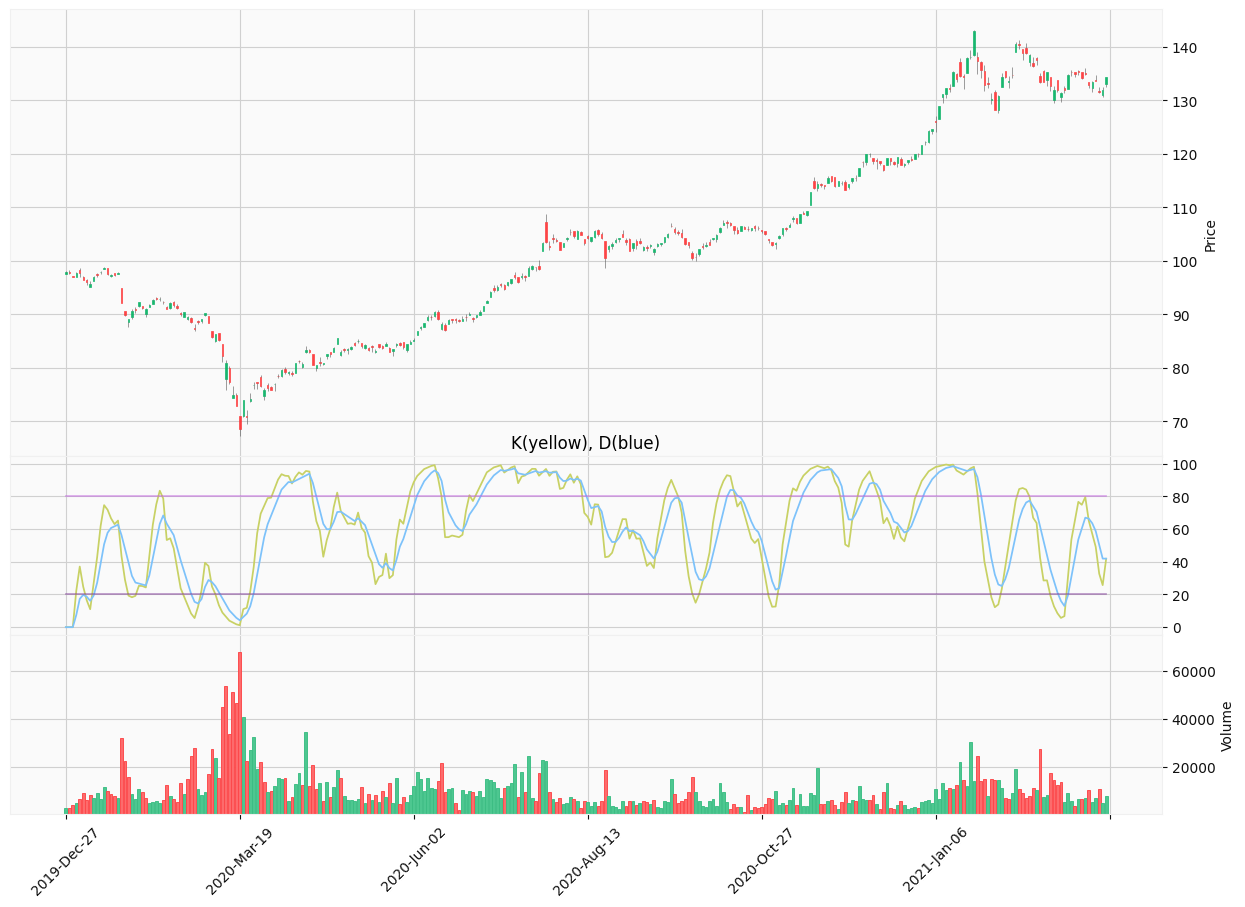

In [72]:
import mplfinance as mpf


plots = [
            # '#c8d164' is yellow
            # '#7dc2fa' is blue
            mpf.make_addplot(data['k'], panel = 1, color='#c8d164', title='K(yellow), D(blue)'),
            mpf.make_addplot(data['d'], panel = 1, color='#7dc2fa'),
    
                # upperbound & lowerbound
            mpf.make_addplot(np.full((len(data['k'])), upperBound), panel = 1, color='#bf5ce0', alpha=0.5),
            mpf.make_addplot(np.full((len(data['d'])), lowerBound), panel = 1, color='#7e3696', alpha=0.5),
]

mpf.plot( data, 
            type='candle',       # candlestick chart of stock price
            volume=True,         # plots trading volume as well
            volume_panel=2,
            figscale=2,          # make graph twice bigger
            style='yahoo',       # color scheme using 'yahoo' style
            addplot = plots,
)      

## 4. 策略1：界外+突破


### 4.1 界外+突破：策略介紹
利用K線在邊界之外並突破D線

買入：K線在20以下，向上突破K線
賣出：K線在80以上，向下突破D線

### 4.2 簡單價線：策略買賣信號

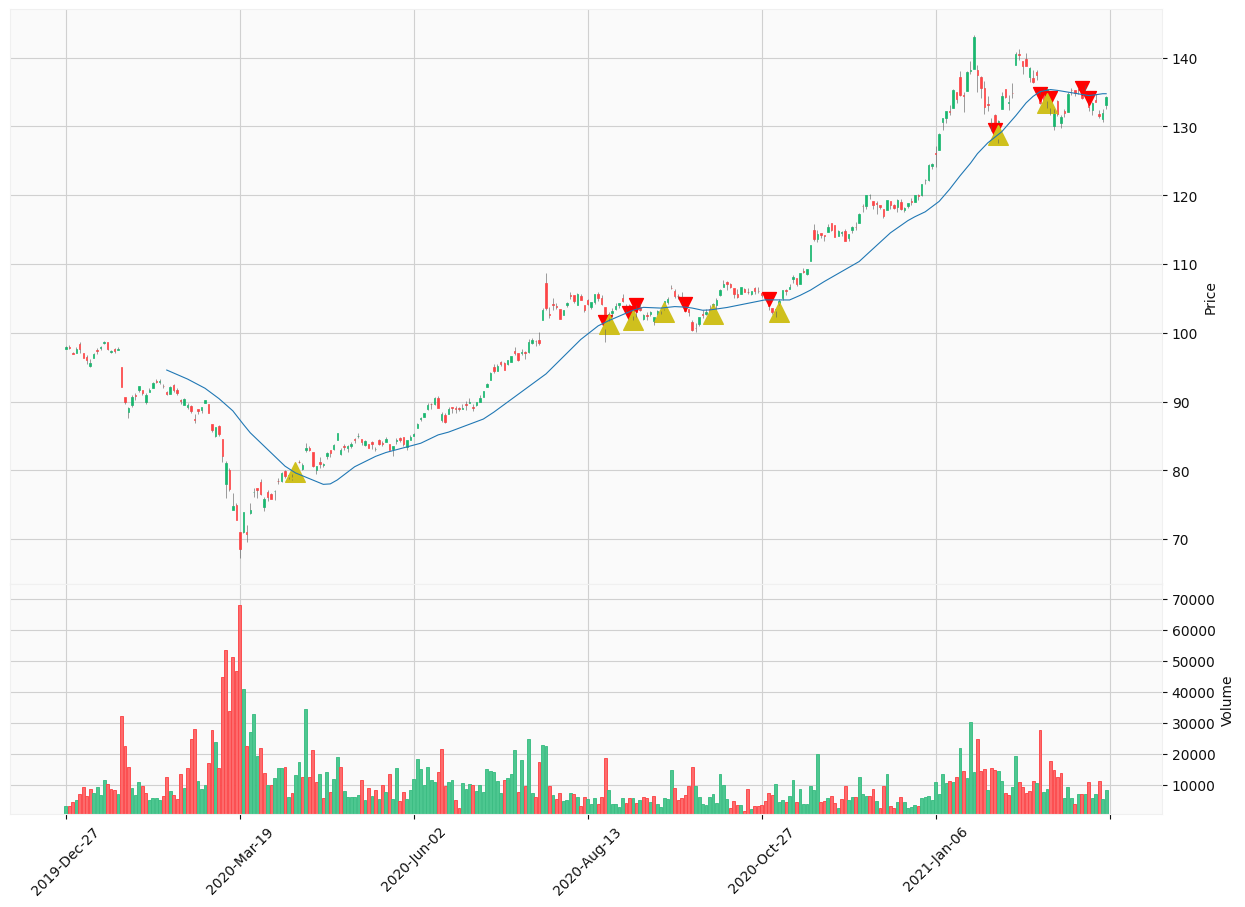

In [95]:
# make a copy from ticker
dw = ticker

# calculate moving average by pandas.DataFrame.rolling()
dw['ma'] = dw['Close'].rolling(MOVING_WINDOW).mean()

# initialize 'buy' & 'sell' column by filling with 0
dw['buy'] = np.zeros(ticker.shape[0])
dw['sell'] = np.zeros(ticker.shape[0])



# the beginning data of MA is nan
# so we skip those data
for i in range(MOVING_WINDOW, dw.shape[0]):

    if(dw['Close'][i] > dw['Open'][i]):
        
        # Close price crossover the MA indicator upward
        if (((dw.iloc[i]['Close'] > dw.iloc[i]['ma']) and
             (dw.iloc[i-1]['Close'] < dw.iloc[i-1]['ma'])) and
             (dw.iloc[i]['Close'] > dw.iloc[i-1]['Close'])):

            # dw['buy'][i] = 1
            #   is a simple version of this line of code
            #   however "chained indexing" should be avoided
            #   while we are setting value.
            #   checkout reference to see more.
            dw.loc[(dw.index[i], 'buy')] = 1

    # Close price crossover the MA indicator downward
    if(dw['Close'][i] < dw['Open'][i]):
        if (((dw.iloc[i]['Close'] < dw.iloc[i]['ma']) and
             (dw.iloc[i-1]['Close'] > dw.iloc[i-1]['ma'])) and
             (dw.iloc[i]['Close'] < dw.iloc[i-1]['Close'])):

            dw.loc[(dw.index[i], 'sell')] = 1
plots = []

# the position in graph
buy, sell = [], []

# adjust the position to avoid signals block the lines
for index, row in dw.iterrows():
    buy.append(row['Close']*0.985 if row['buy'] else np.nan)
    sell.append(row['Close']*1.01 if row['sell'] else np.nan)

# np.isnan(sell) determine the value is nan or not
# count_nonzero(np.isnan(sell)) counts how many nan we have
# if nan amount equal the length of array, we don't have sell record
if not np.count_nonzero(np.isnan(sell)) == len(sell):
    plots.append(mpf.make_addplot(sell , type = 'scatter', color = 'red', marker = 'v', markersize = 100))

if not np.count_nonzero(np.isnan(buy)) == len(buy):
    plots.append(mpf.make_addplot(buy , type = 'scatter', color = '#cfc01d', marker = '^', markersize = 200))

mpf.plot(dw, 
            addplot = plots,
            type='candle',       # candlestick chart of stock price
            mav = MOVING_WINDOW, # mav is moving average window
            volume=True,         # plots trading volume as well
            figscale=2,          # make graph twice bigger
            style='yahoo')       # color scheme using 'yahoo' style



## 5. 策略2：黃金交叉與死亡交叉

### 5.1 黃金交叉與死亡交叉：策略介紹
利用兩條MA線之間的交叉為基準判斷買賣點

買入：五日線和月線黃金交叉
賣出：五日線和月線死亡交叉

### 5.2 黃金交叉與死亡交叉：策略買賣信號

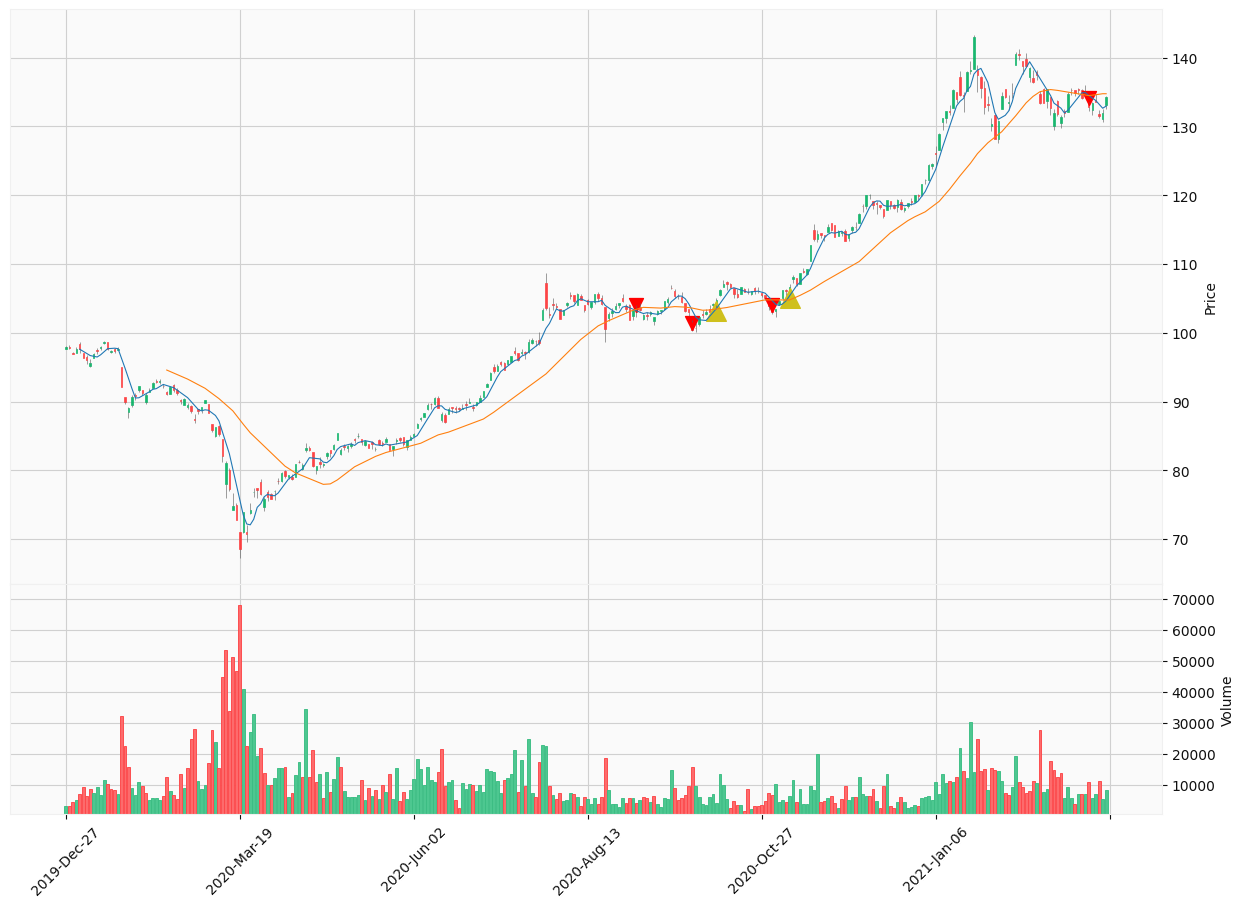

In [99]:
# make a copy from ticker
dw = ticker

MOVING_WINDOW_1 = 5
MOVING_WINDOW_2 = 30
# calculate moving average by pandas.DataFrame.rolling()
dw['ma_5'] = dw['Close'].rolling(MOVING_WINDOW_1).mean()
dw['ma_30'] = dw['Close'].rolling(MOVING_WINDOW_2).mean()

# initialize 'buy' & 'sell' column by filling with 0
dw['buy'] = np.zeros(ticker.shape[0])
dw['sell'] = np.zeros(ticker.shape[0])



# the beginning data of MA is nan
# so we skip those data
for i in range(MOVING_WINDOW_2, dw.shape[0]):

    if(dw['Close'][i] > dw['Open'][i]):
        
        # Close price crossover the MA indicator upward
        if (((dw.iloc[i]['ma_5'] > dw.iloc[i]['ma_30']) and
             (dw.iloc[i-1]['ma_5'] < dw.iloc[i-1]['ma_30'])) and
             (dw.iloc[i]['ma_5'] > dw.iloc[i-1]['ma_5'])):

            # dw['buy'][i] = 1
            #   is a simple version of this line of code
            #   however "chained indexing" should be avoided
            #   while we are setting value.
            #   checkout reference to see more.
            dw.loc[(dw.index[i], 'buy')] = 1

    # Close price crossover the MA indicator downward
    if(dw['Close'][i] < dw['Open'][i]):
        if (((dw.iloc[i]['ma_5'] < dw.iloc[i]['ma_30']) and
             (dw.iloc[i-1]['ma_5'] > dw.iloc[i-1]['ma_30'])) and
             (dw.iloc[i]['ma_5'] < dw.iloc[i-1]['ma_5'])):

            dw.loc[(dw.index[i], 'sell')] = 1
plots = []

# the position in graph
buy, sell = [], []

# adjust the position to avoid signals block the lines
for index, row in dw.iterrows():
    buy.append(row['Close']*0.985 if row['buy'] else np.nan)
    sell.append(row['Close']*1.01 if row['sell'] else np.nan)

# np.isnan(sell) determine the value is nan or not
# count_nonzero(np.isnan(sell)) counts how many nan we have
# if nan amount equal the length of array, we don't have sell record
if not np.count_nonzero(np.isnan(sell)) == len(sell):
    plots.append(mpf.make_addplot(sell , type = 'scatter', color = 'red', marker = 'v', markersize = 100))

if not np.count_nonzero(np.isnan(buy)) == len(buy):
    plots.append(mpf.make_addplot(buy , type = 'scatter', color = '#cfc01d', marker = '^', markersize = 200))

mpf.plot(dw, 
            addplot = plots,
            type='candle',       # candlestick chart of stock price
            mav = (MOVING_WINDOW_1, MOVING_WINDOW_2), # mav is moving average window
            volume=True,         # plots trading volume as well
            figscale=2,          # make graph twice bigger
            style='yahoo')       # color scheme using 'yahoo' style



## 6. 用買賣信號進行回測

In [100]:
# how many shares we hold, and the money balance
have_shares , balance = 0, 0

# multiple buy and 1 sell as "a trade"
# record trading times and how many trade are making money
make_money, trade_times = 0, 0

# we use geometic average
# this is products of return rate
return_rate = 1
for index, row in dw.iterrows():
    
    if(row['buy'] == 1):
        balance -= row['Close']
        have_shares += 1
        print('buy ', row['Close'])
    
    # sell signal and we have some shares
    elif(row['sell'] == 1 and have_shares != 0):
        
        
        print('sell', row['Close'], "*" , have_shares)
        
        principal = -balance
        balance += row['Close'] * have_shares
        
        # to calculate accuracy
        trade_times += 1
        if(balance > 0):
            make_money += 1
            
        # plus 1 avoiding get too small
        return_rate *= 1+(balance / principal)
        
        # reset balance & shares
        balance = 0
        have_shares = 0
      

print()
print('cumulative return rate :', (return_rate-1) * 100, '%')
if(trade_times != 0):
    print('accuracy :', make_money/ trade_times * 100, '%')

buy  104.8
sell 103.0 * 1
buy  106.7
sell 132.8 * 1

cumulative return rate : 22.323415154138402 %
accuracy : 50.0 %


---
Other reference：
* [TA-lib KD指標](http://www.tadoc.org/indicator/STOCH.htm)
